<a href="https://colab.research.google.com/github/RashmiSunkara/Big-Mart-sales-Prediction/blob/main/sales_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset contains information about the stores, products and historical sales. We will predict the sales of the products in the stores.

We will start by building a prototype machine learning pipeline that will help us define the actual machine learning pipeline.

In [ ]:
#Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Exploration and Preprocessing

In [ ]:
#loading train data
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1249/Train.csv")

In [ ]:
#check for missing values
train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Only Item_Weight and Outlet_Size have missing values.

Item_Weight is a continuous variable. We can use either mean or median to compute the missing values, but here we will use mean.

Outlet_Size is a categorical variable so will use mode to compute the missing values in the column.

In [ ]:
#impute missing values in Item_Weight using mean
train.Item_Weight.fillna(train.Item_Weight.mean(), inplace=True)
train.Item_Weight.isna().sum()

0

In [ ]:
#impute missing values in Outlet_Size using mode
train.Outlet_Size.fillna(train.Outlet_Size.mode()[0], inplace=True)
train.Outlet_Size.isna().sum()

0

Machine learning models cannot work with categorical(string) data. We will convert the categorical variables into numeric types.

In [ ]:
#checking categorical variables in the data
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

Our data has the following categorical variables

* Item_Identifier
* Item_Fat_Content
* Item_Type
* Outlet_Identifier
* Outlet_Size
* Outlet_Type
* Outlet_Location_Type

We will use the categorical_encorders library to convert these variables into binary variables. We will not convert Item_Identifier.

In [ ]:
! pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.6 MB/s eta 0:00:00


In [ ]:
#from sklearn.preprocessing import CategoricalEncoder
import category_encoders as ce

#create an object of OneHotEncorder
OHE = ce.OneHotEncoder(cols=['Item_Fat_Content',
                            'Item_Type',
                            'Outlet_Identifier',
                            'Outlet_Size',
                            'Outlet_Location_Type',
                            'Outlet_Type'],use_cat_names=True)

#encode the variables
train = OHE.fit_transform(train)

In [ ]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_LF,Item_Fat_Content_reg,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,Item_Type_Snack Foods,Item_Type_Frozen Foods,Item_Type_Breakfast,Item_Type_Health and Hygiene,Item_Type_Hard Drinks,Item_Type_Canned,Item_Type_Breads,Item_Type_Starchy Foods,Item_Type_Others,Item_Type_Seafood,Item_MRP,Outlet_Identifier_OUT049,Outlet_Identifier_OUT018,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT027,Outlet_Identifier_OUT045,Outlet_Identifier_OUT017,Outlet_Identifier_OUT046,Outlet_Identifier_OUT035,Outlet_Identifier_OUT019,Outlet_Establishment_Year,Outlet_Size_Medium,Outlet_Size_High,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,9.30,1,0,0,0,0,0.016047,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,249.8092,1,0,0,0,0,0,0,0,0,0,1999,1,0,0,1,0,0,1,0,0,0,3735.1380
1,DRC01,5.92,0,1,0,0,0,0.019278,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48.2692,0,1,0,0,0,0,0,0,0,0,2009,1,0,0,0,1,0,0,1,0,0,443.4228
2,FDN15,17.50,1,0,0,0,0,0.016760,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,141.6180,1,0,0,0,0,0,0,0,0,0,1999,1,0,0,1,0,0,1,0,0,0,2097.2700
3,FDX07,19.20,0,1,0,0,0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,182.0950,0,0,1,0,0,0,0,0,0,0,1998,1,0,0,0,1,0,0,0,1,0,732.3800
4,NCD19,8.93,1,0,0,0,0,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,53.8614,0,0,0,1,0,0,0,0,0,0,1987,0,1,0,0,1,0,1,0,0,0,994.7052


Now that we have taken care of our categorical variables, we move on to the continous variables.
We will nnormalize the data in such a way that the range of all variables is almost similar.
We will use the StandardScaler function to do this.

In [ ]:
from sklearn.preprocessing import StandardScaler
#create an object of the StandardScaler
scaler = StandardScaler()

#fit with the Item_MRP
scaler.fit(np.array(train.Item_MRP).reshape(-1,1))

#transform the data
train.Item_MRP = scaler.transform(np.array(train.Item_MRP).reshape(-1,1))

# Building the Model
We will use the Linear Regression and the Random Forest Regressor to predict the sales. We will create a validation set using the train_test_split() function.

test_size = 0.25 such that the validation set holds 25% of the data points while the train set has 75%.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#seperate the independent and target variable
train_X = train.drop(columns=['Item_Identifier', 'Item_Outlet_Sales'])
train_Y = train['Item_Outlet_Sales']

#split the data
train_x, valid_x, train_y, valid_y = train_test_split(train_X, train_Y, test_size=0.25)

#shape of train test splits
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((6392, 45), (2131, 45), (6392,), (2131,))

Now that we have split our data, we will train a linear regression model on this data and check its performance on the validation set. We will use RMSE as an evaluation metric.

In [ ]:
#LinearRegression
LR = LinearRegression()

#fit the model
LR.fit(train_x, train_y)

#predict the target on train and validation data
train_pred = LR.predict(train_x)
valid_pred = LR.predict(valid_x)

# RMSE on train and validation data
print('RMSE on train data: ', mean_squared_error(train_y, train_pred)**(0.5))
print('RMSe on validation data: ', mean_squared_error(valid_y, valid_pred)**(0.5))

RMSE on train data:  1144.8779260962901
RMSe on validation data:  1074.0059358082922


We will train a random forest regressor and see if we can get an improvement on the train and validation errors.

In [ ]:
#RandomForestRegressor
RFR = RandomForestRegressor(max_depth=10)

#fitting the model
RFR.fit(train_x, train_y)

#predict the target on train and validation data
train_pred = RFR.predict(train_x)
valid_pred = RFR.predict(valid_x)

#RMSE on train and test data
print('RMSE on train data :', mean_squared_error(train_y, train_pred)**(0.5))
print('RMSE on validation data :', mean_squared_error(valid_y, valid_pred)**(0.5))


RMSE on train data : 919.2447494685077
RMSE on validation data : 1028.5767937564954


We can see a significant improvement on the RMSE values. The random forest algorithm gives us 'feature importance for all the variables in the data.

We have 45 features and not all of these features may be useful in forecasting. We will select the top 7 features which had a major contribution in forecasting sales values.

If the model performance is similar in both cases (by using 45 features and by using 7 features), then we should only use the top 7 features, in order to keep the model simple and efficient.

The goal is to have a less complex model without compromising on the overall model performance.

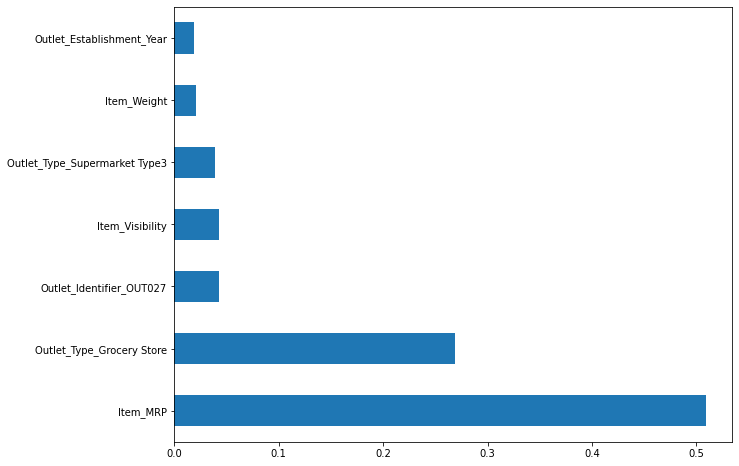

In [ ]:
#plot the 7 most important features
plt.figure(figsize=(10,8))
feat_importances = pd.Series(RFR.feature_importances_, index = train_x.columns)
feat_importances.nlargest(7).plot(kind='barh');

In [ ]:
#training data with top 7 features
train_x_7 = train_x[['Item_MRP',
                      'Outlet_Type_Grocery Store',
                      'Item_Visibility',
                      'Outlet_Identifier_OUT027',
                      'Outlet_Type_Supermarket Type3',
                      'Item_Weight',
                      'Outlet_Establishment_Year']]

#validation data with top 7 important features
valid_x_7 = valid_x[['Item_MRP',
                      'Outlet_Type_Grocery Store',
                      'Item_Visibility',
                      'Outlet_Identifier_OUT027',
                      'Outlet_Type_Supermarket Type3',
                      'Item_Weight',
                      'Outlet_Establishment_Year']]

#create an object of the RandomForestRegressor Model
RFR_with_7 = RandomForestRegressor(max_depth=10, random_state=2)


In [ ]:
#fit the model
RFR_with_7.fit(train_x_7, train_y)

#predict the target on the training and validation data
pred_train_with_7 = RFR_with_7.predict(train_x_7)
pred_valid_with_7 = RFR_with_7.predict(valid_x_7)

#RMSE on train and validation data
print('RMSE on train data: ', mean_squared_error(train_y, pred_train_with_7)**(0.5))
print('RMSE on validation data: ', mean_squared_error(valid_y, pred_valid_with_7)**(0.5))

RMSE on train data:  924.4489368280147
RMSE on validation data:  1037.6454745351446


Using only 7 features has given us almost the same perfomance as the previous model where we were using 45 features. Now we will identify the final set of features that we need and the preprocessing steps for each of them.

# Identifying features to build the Machine Learning pipeline
We must list down the final set of features and necessary preprocessing steps for each of them, to be used in the ML pipeline. Since the RandomForestRegressor model with 7 features gave us almost the same performance as the previous model with 45 features, we will only use these features for our ML pipeline.

# Selected features and preprocessing steps
* **Item_MRP:** It holds the price of the products. During the preprocessing step we used a standard scaler to scale these values.
* **Outlet_Type_Grocery Store:** A binary column which indcates if the outlet type is a grocery store or not. To use this information in the model building process, we will add a binary feature in the existing data that contains 1 (if outlet type is a grocery store) and 0 (if the outlet type is something else).
* **Item_Visibility:** Denotes visibility of products in the store. Since this variable had a small value range and no missing values, we did not apply any preprocessing steps on this variable.
* **Outlet_Type_Supermarket Type3:** Another binary column indicating if the outlet type is a 'supermarket_type_3' or not. To capture this information we will create a binary feature that stores 1 (if outlet type is supermarket_type_3) and 0 (if not).
* **Outlet_Identifier_OUT027:8** This feature specifies whether the outlet identifier is 'OUT027' or not. Similar to the  previous example, we will create a seperate column that carries 1 (if outlet identifier is OUT027) or 0 (if otherwise).
* **Outlet_Establishment_Year:** This describes the year of establishment of the stores. Since we did not perform any transformation on values in this column, we will not preprocess it in the pipeline.
* **Item_Weight:** During preprocessing we observed that this column had missing values. These missing values were imputed using the average of the column. This has to be taken into account while building the pipeline.

We will drop the other columns since we will not use them to train the model.


# Pipeline Design
We have built a prototype to understand the preprocessing requirement for our data. It is now time to form a pipeline design based on our learning from the prototype. We will define the pipeline in 3 stages:

1. Create the required binary features
2. Perform required data preprocessing and transformations:
*  Drop the columns that are not required
*  Missing value imputation (Item_Weight) by average
*  Scale the Item_MRP
3. Random Forest Regressor

# 1. Create the required binary features
We will create a custom transformer that will add 3 new binary columns to the existing data.

* Outlet_Type: Grocery Store
* Outlet_Type: Supermarket Type3
* Outlet_Identifier_OUT027

# 2. Data Preprocessing and transformations
We will use a column transformer to do the required transformations. It will contain 3 steps:

* Drop the columns that are not required for model training
* Impute missing values in the column Item_Weight using the average
* Scale the column Item_MRP using StandardScaler()

# 3. Use the model to predict the target on the cleaned data
This will be the final step in the pipeline. In the last two steps we preprocessed the data and made it ready for the model building process. We will use this data and build a machine learning model to predict the Item Outlet Sales.

# Building the pipeline
We will read the data set and seperate the independent and target variable from the training dataset.

In [ ]:
#importing required libraries
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [ ]:
#read training dataset
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1249/Train.csv")

In [ ]:
#seperate the independent and target variables
train_x = train.drop(columns=['Item_Outlet_Sales'])
train_y = train['Item_Outlet_Sales']

We need to create 3 new binary columns using a custom transformer. Here are the steps we need to follow to create a custom transformer.

* Define a class OutletTypeEncoder
* Add the parameter BaseEstimator while defining the class
* The class must contain fit and transform methods
* In the transform method, we will define all the 3 columns that we want after the first stage in our ML pipeline.

In [ ]:
# import the BaseEstimator
from sklearn.base import BaseEstimator

# define the class OutletTypeEncoder
# This will be our custom transformer that will create 3 new binary columns
# custom transformer must have methods fit and transform

class OutletTypeEncoder(BaseEstimator):

    def __init__(self):
        pass

    def fit(self, documents, y=None):
        return self

    def transform(self, x_dataset):
        x_dataset['outlet_grocery_store'] = (x_dataset['Outlet_Type'] == 'Grocery Store')*1
        x_dataset['outlet_supermarket_3'] = (x_dataset['Outlet_Type'] == 'Supermarket Type3')*1
        x_dataset['outlet_identifier_OUT027'] = (x_dataset['Outlet_Identifier'] == 'OUT027')*1

        return x_dataset

Next we will define the pre-processing steps required before the model building process.

* Drop the columns – Item_Identifier, Outlet_Identifier, Item_Fat_Content, Item_Type, Outlet_Identifier, Outlet_Size, Outlet_Location_Type and Outlet_Establishment_Year
* Impute missing values in column Item_Weight with mean
* Scale the column Item_MRP using StandardScaler().
This will be the second step in our machine learning pipeline. After this step, the data will be ready to be used by the model to make predictions.

In [ ]:
# Drop the columns -
# Impute the missing values in column Item_Weight by mean
# Scale the data in the column Item_MRP
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
pre_process = ColumnTransformer(remainder='passthrough',
                                transformers=[('drop_columns', 'drop', ['Item_Identifier',
                                                                        'Outlet_Identifier',
                                                                        'Item_Fat_Content',
                                                                        'Item_Type',
                                                                        'Outlet_Identifier',
                                                                        'Outlet_Size',
                                                                        'Outlet_Location_Type',
                                                                        'Outlet_Type'
                                                                       ]),
                                              ('impute_item_weight', SimpleImputer(strategy='mean'), ['Item_Weight']),
                                              ('scale_data', StandardScaler(),['Item_MRP'])])

# Predict the target
This will be the final block of the machine learning pipeline. We will specify 3 steps – create binary columns, preprocess the data, train a model.

When we use the fit() function with a pipeline object, all three steps are executed. Post the model training process, we use the predict() function that uses the trained model to generate the predictions.

In [ ]:
pip install transformers

     |████████████████████████████████| 3.4 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 
     |████████████████████████████████| 61 kB 445 kB/s 
     |████████████████████████████████| 596 kB 46.1 MB/s 
     |████████████████████████████████| 3.3 MB 25.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Define the Pipeline
"""
Step1: get the oultet binary columns
Step2: pre processing
Step3: Train a Random Forest Model
"""
from sklearn.pipeline import Pipeline
model_pipeline = Pipeline(steps=[('get_outlet_binary_columns', OutletTypeEncoder()),
                                 ('pre_processing',pre_process),
                                 ('random_forest', RandomForestRegressor(max_depth=10,random_state=2))
                                 ])
# fit the pipeline with the training data
model_pipeline.fit(train_x,train_y)

# predict target values on the training data
model_pipeline.predict(train_x)

array([4348.01437159,  693.40276088, 2323.35268531, ..., 1300.83665376,
       1508.86795688, 1152.35475793])

Now, we will read the test data set and we call predict function only on the pipeline object to make predictions on the test data.

In [ ]:
# read the test data
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1249/Test.csv")

# predict target variables on the test data
y_sub = model_pipeline.predict(test_data)

In [ ]:
y_sub

array([1646.0548363 , 1305.4298012 ,  649.26184297, ..., 1848.60226305,
       3959.67937864, 1384.01466986])

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/1249/Submission.csv")
sub["Item_Outlet_Sales"] = y_sub
sub.head()

,Unnamed: 0,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,0,FDW58,OUT049,1646.054836
1,1,FDW14,OUT017,1305.429801
2,2,NCN55,OUT010,649.261843
3,3,FDQ58,OUT017,2329.787295
4,4,FDY38,OUT027,5929.857776


In [ ]:
sub.to_csv("/content/drive/MyDrive/Colab Notebooks/1249/Sub2.csv", index=False)